#### Project Description
The project aims to train machine learning models for cervical cancer classification based on risk factors to accurately detect individuals with a high risk of cervical cancer, enabling timely intervention and necessary medical attention

#### Import libraries

In [ ]:
%config Completer.use_jedi=False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, \
    ConfusionMatrixDisplay, classification_report, precision_score, \
    f1_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#### Load the dataset

In [ ]:
# The dataset uses '?' to represent missing values
# Replace '?' with NaN values
df = pd.read_csv('risk_factors.csv', na_values='?')

#### Understanding the Data
The dataset was retrieved from 'Hospital Universitario de Caracas' in Caracas, Venezuela. It consists of 858 rows and 36 columns. 4 out of the 36 columns are target variables — Hinselmann, Schiller, Citology and Biopsy. Biopsy was chosen as the target variable for this project.

##### Data Cleaning
From observation, the dataset had many missing values, especially feature 26() and feature 27. These 2 features were dropped from the dataset as there were not enough samples to provide meaningful insights. As for the remaining features, missing values were imputed by taking their median values.

##### Oversampling
A histogram was plotted to examine the distribtution of samples in the target variable Biopsy. The dataset was not balanced. The distribution was biased towards the '0' class (803 samples) compared to the '1' class (55 samples).


To address the imbalance, SMOTE oversampling method was performed to generate new samples from the minority class. After oversampling, each target class was balanced at 803 samples.

In [ ]:
# Get a brief summmary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

In [ ]:
# Get the unique values in each column
pd.Series({column : df[column].unique() for column in df})

Age                                   [18, 15, 34, 52, 46, 42, 51, 26, 45, 44, 27, 4...
Number of sexual partners             [4.0, 1.0, 5.0, 3.0, 2.0, 6.0, nan, 7.0, 15.0,...
First sexual intercourse              [15.0, 14.0, nan, 16.0, 21.0, 23.0, 17.0, 26.0...
Num of pregnancies                    [1.0, 4.0, 2.0, 6.0, 3.0, 5.0, nan, 8.0, 7.0, ...
Smokes                                                                  [0.0, 1.0, nan]
Smokes (years)                        [0.0, 37.0, 34.0, 1.266972909, 3.0, 12.0, nan,...
Smokes (packs/year)                   [0.0, 37.0, 3.4, 2.8, 0.04, 0.5132021277, 2.4,...
Hormonal Contraceptives                                                 [0.0, 1.0, nan]
Hormonal Contraceptives (years)       [0.0, 3.0, 15.0, 2.0, 8.0, 10.0, 5.0, 0.25, 7....
IUD                                                                     [0.0, 1.0, nan]
IUD (years)                           [0.0, 7.0, nan, 5.0, 8.0, 6.0, 1.0, 0.58, 2.0,...
STDs                            

In [ ]:
# Remove feature 26 and 27 as they have too many null values

df = df.drop(df.columns[26:28], axis=1)

df.shape

(858, 34)

In [ ]:
# Impute nul values in features with their median
df = df.fillna(df.median())

df.isnull().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


In [ ]:
# Take Biopsy as the target variable
X = df.iloc[:,:-4].values
y = df.iloc[:,-1].values

print(X.shape)
print(y.shape)

(858, 30)
(858,)


Text(0.5, 1.0, 'Distribution of classes in Biopsy')

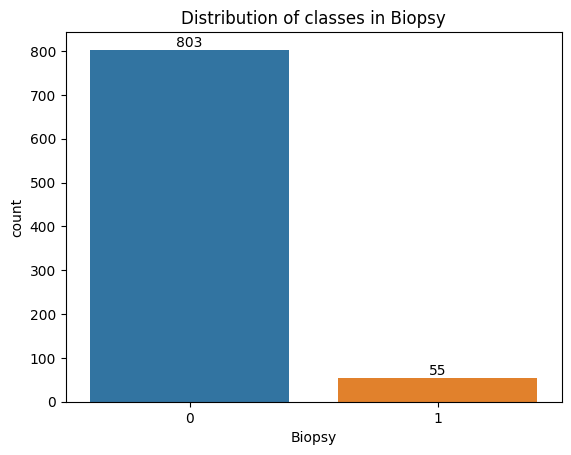

In [ ]:
# Plot histogram to show distribution of classes in Biopsy
ax = sns.countplot(x=df["Biopsy"])
ax.bar_label(ax.containers[0])
ax.set_title("Distribution of classes in Biopsy")

In [ ]:
# Perform SMOTE oversampling on the minority class to balance the dataset
sm = SMOTE(sampling_strategy='minority', random_state=42)
X, y = sm.fit_resample(X, y)

print(X.shape)
print(y.shape)

(1606, 30)
(1606,)


Text(0.5, 1.0, 'Distribution of classes in Biopsy')

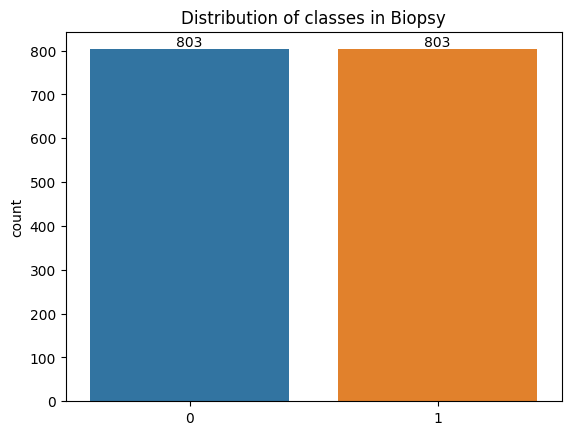

In [ ]:
# Plot histogram to show distribution of classes in Biopsy after oversampling
ax = sns.countplot(x=y)
ax.bar_label(ax.containers[0])
ax.set_title("Distribution of classes in Biopsy")

#### Split the dataset
Split the dataset into training, validation and test sets.

In [ ]:
# Stratify the split to ensure that each class is represented
# Do an 8:2 split for training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.2, random_state=42)

# Use training set to split 8:2 for validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train,
                                                      test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(1027, 30)
(322, 30)
(257, 30)


#### Data preprocessing
Perform data preprocessing such as normalization, standardization, label encoding etc.
______________________________________________________________________________________
Description:
For data preprocessing, feature scaling was performed so that the models based on gradient descent would converge faster.
The feature scaling method used wa standardisation, where the features are scaled to have zero mean, $\mu = 0$ and standard deviation, $\sigma = 1$. The `StandardScaler` class from sklearn was used.

First, the scaler was fitted with the input features of the training set. The same scaler was then used to transform the input features of the training, validatoin and test set for consistent scaling.

Label encoding was not required as the features of our dataset were already in numerical format.

In [ ]:
# Perform standardisation
scaler = StandardScaler()
scaler.fit(X_train)

# Transform the input features with the fitted scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

#### Feature Selection
Perform feature selection to select the relevant features.
______________________________________________________________________________________
Description:
The feature selection method used was tree-based feature selection. Selection was performed based on the mean decrease in impurity by using random forests.

First, a `RandomForestClassifier` was fitted with the training data. Then, `SelectFromModel` was used to train a model with the selected features, and transform the features of the training, validation and test set. This discards the irrelevant features from the feature space.
As a result, the initial 34 features were reduced to 9 features.

The selected features and their feature importance scores are shown in the plot below.

Age                                0.103227
Number of sexual partners          0.108693
First sexual intercourse           0.101889
Num of pregnancies                 0.117187
Hormonal Contraceptives            0.095339
Hormonal Contraceptives (years)    0.113031
Dx:Cancer                          0.035878
Dx:HPV                             0.043655
Dx                                 0.040320
dtype: float64


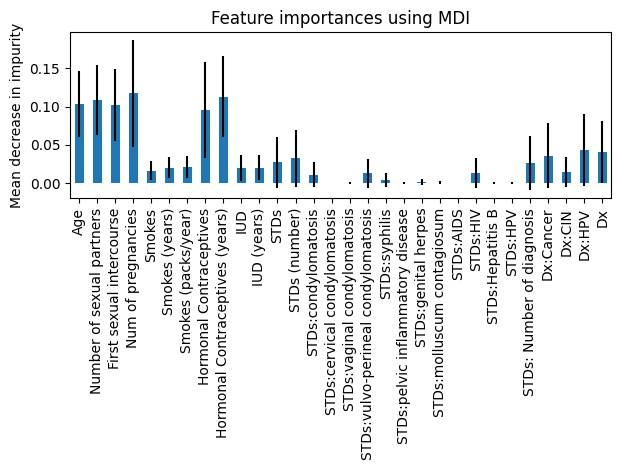

In [ ]:
# Train a random forest to compute impurity-based feature importance
random_forest = RandomForestClassifier(random_state=42)
# Fit the model with the training data
random_forest.fit(X_train, y_train)

# Select the important features for model training
feature_selector = SelectFromModel(random_forest, prefit=True)

# Print the selected features
feature_names = df.columns[:30].tolist()
feature_importance = pd.Series(random_forest.feature_importances_, index=feature_names)
print(feature_importance[feature_selector.get_support()])

# Plot a graph of feature importances
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

fig, ax = plt.subplots()
feature_importance.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [ ]:
# Transform the input features of training, validation and testing set
# to include only the selected features
X_train = feature_selector.transform(X_train)
X_test = feature_selector.transform(X_test)
X_valid = feature_selector.transform(X_valid)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(1027, 9)
(322, 9)
(257, 9)


#### Data modeling
Build the machine learning models. You must build atleast two (2) predictive models. One of the predictive models must be either Decision Tree or Support Vector Machine.
______________________________________________________________________________________
Description:

Neural network(NN), decision tree(DT) and support vector machine(SVM) models were built.

The training set was used to train the models. The validation set was used to evaluate the trained model's performance with the parameters that were chosen. This procedure was repeated until a set of optimal parameters for the model was found. The final performance of the model was then evaluated by predicting the test set.
In cancer prediction, because only a small number of patients would be diagnosed with cancer, accuracy was not a suitable metric given the nature of the problem. AUC-ROC and F1-score were chosen instead. AUC-ROC evaluates a model's discriminatory power by taking into account trade-offs between sensitivity and specificity. F1-score is the harmonic mean between precision and recall. These two metrics were suitable for binary classification with imbalanced datasets. In general, the macro averages were taken for more representative results.


The first model is NN. A multilayer perceptron(MLP) with three layers was defined here(1 input layer, 1 hidden layer, and 1 output layer). Rectified linear unit(ReLU) was the activation function used in the hidden layer. The sigmoid activation function was chosen for the output layer to produce probabilities between 0 and 1.
The number of hidden units in each layer, batch size, and number of iterations were tuned. By increasing the number of hidden units, the number of trainable parameters increases at the expense of overfitting. The number of samples fed to the model for weight updates during gradient descent is determined by the batch size. For optimization, the loss function chosen was binary cross entropy as this was a binary classification problem.
Initially, grid search was tested to find the set of optimal parameters for MLP. This method, however, was too expensive to compute. Instead, the trial-and-error method was used for tuning. To reduce overfitting, the dropout method was also used. According to our experiments, introducing a dropout layer yielded better results without slowing down training. L2 regularization was also experimented with but produced worse results. This suggests that L2 regularization was not suitable for this problem as it was unable to learn patterns in the small dataset.


The second model is DT. DT has many parameters that can be tuned to control its splits. For our experiments, we limited the parameters to the type of measuring function(`criterion`), minimum number of samples for a split(`min_samples_split`), the maximum depth of the tree(`max_depth`), the minimum number of samples at the leaves(`min_samples_leaf`), and the minimum impurity decrease(`min_impurity_decrease`). This set of parameters was used in grid search to find the best parameters for the DT. Then, a DT classifier was trained using the parameters found by grid search, and its structure was visualized.


The third and last model is SVM. We used grid search to train the model for every combination of hyperparameter values specified namely (`C`), (`gamma`), and (`kernel`). To keep the class ratio in the folds created the same as the training set, we implemented (`StratifiedKFold`) as the cross-validation.

*   (`n_splits=3`) = 3-fold cross-validation
*   (`shuffle=True`) = Dataset is shuffled before splitting
*   (`random_state=0`) = Shuffle is reproducible

Next, we defined the grid search using (`GridSearchCV`).

*   (`estimator=svm`) = Support Vector Classifier as the model
*   (`param_grid=param_grid`) = Takes pre-defined search space for the grid search
*   (`scoring='accuracy'`) = Sets the performance evaluation metric
*   (`refit='accuracy'`) = Enables model refitting with the best parameters
*   (`n_jobs=-1`) = Parallel processing to reduce the training time
*   (`cv=svm_kfold`) = Takes the (`StratifiedKFold`) that we have defined
*   (`verbose`) = Controls the number of messages returned by the grid search. Here, (`verbose=0`) means no messages will be returned


The parameters used to train each model is summarized in the table below.

|Model|Parameters|
|---|---|
|MLP|hidden units=32, dropout rate=0.3, batch size=64, epochs=256|
|DT|criterion': 'entropy', 'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2|
|SVM|'C': 1, 'gamma': 1, 'kernel': 'rbf'|

##### Neural Network


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                320       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
training time = 44.8601 seconds


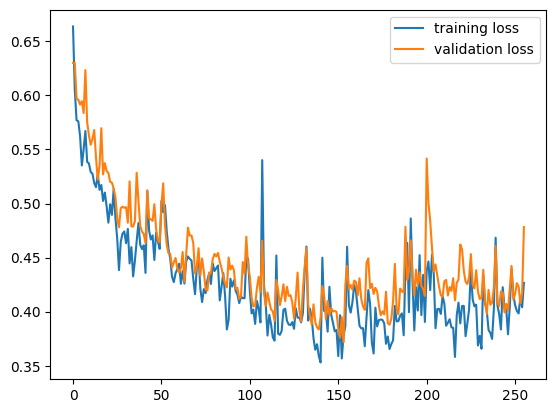

In [ ]:
# Define a 3 layer MLP
mlp = Sequential([
    # Input layer
    tf.keras.layers.Input(shape=(9,)),
    # Hidden layer
    tf.keras.layers.Dense(32, activation='relu', dtype='float64'),
    tf.keras.layers.Dropout(rate=0.3),  # Dropout method
    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid', dtype='float64')
])

mlp.compile(optimizer=Adam(learning_rate=0.03),
                    loss='binary_crossentropy',
                    metrics=['AUC'])

mlp.summary()

start_time = time.time()
# Train the MLP
history = mlp.fit(X_train, y_train,
                          validation_data=(X_valid, y_valid),
                          batch_size=64, epochs=256, verbose=0)
end_time = time.time()
print(f'training time = {end_time-start_time:.4f} seconds')

# Plot the training loss and validation loss
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()
plt.show()

##### Decision Tree

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
{'criterion': 'entropy', 'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       129
           1       1.00      0.63      0.78       128

    accuracy                           0.82       257
   macro avg       0.87      0.82      0.81       257
weighted avg       0.87      0.82      0.81       257



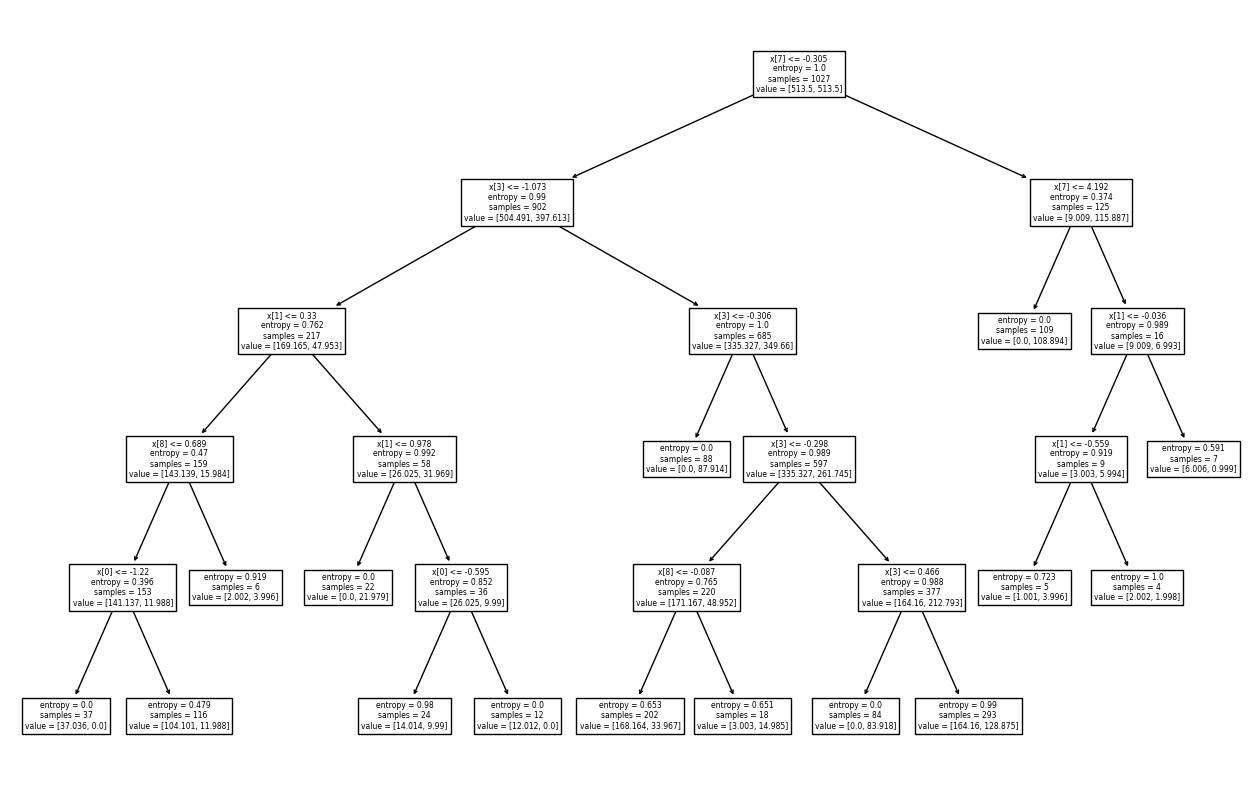

In [ ]:
# Grid search to tune hyperparameters

# Define a base decision tree
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Define parameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 4],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_impurity_decrease': [0.0, 0.1, 0.2]
}

# Perform grid search
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                          scoring='roc_auc', verbose=1, cv=5)
grid_search.fit(X_train, y_train)

# Print the searched parameters
print(grid_search.best_params_)

# Train the tuned decision tree
dt = DecisionTreeClassifier(**grid_search.best_params_,
                           class_weight='balanced',
                           random_state=42)
dt.fit(X_train, y_train)

# Evaluate the decision tree
y_pred = dt.predict(X_valid)
print(classification_report(y_valid, y_pred))

# Visualize the decision tree
plt.figure(figsize=(16, 10))
plot_tree(dt)
plt.show()

SVM


Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       129
           1       0.92      0.90      0.91       128

    accuracy                           0.91       257
   macro avg       0.91      0.91      0.91       257
weighted avg       0.91      0.91      0.91       257



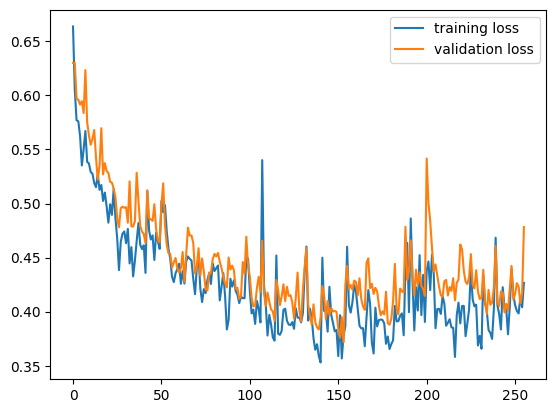

In [ ]:
# Grid search to tune hyperparameters

# Define a base SVM
svm = SVC(gamma='auto', random_state=42)

#Define parameters to tune
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}

# Define k-fold cross-validation
svm_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Perform grid search
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid,
                           scoring='accuracy', refit='accuracy',
                           n_jobs=-1, cv=svm_kfold, verbose=0)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("\nBest Parameters:", grid_search.best_params_)

# Train the tuned SVM classifier
svm = SVC(**grid_search.best_params_, random_state=42)
svm.fit(X_train, y_train)

# Evaluate the SVM classifier
y_pred = svm.predict(X_valid)
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

# Plot the training loss and validation loss
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()
plt.show()

#### Evaluate the models
Perform a comparison between the predictive models. <br>
Report the accuracy, recall, precision and F1-score measures as well as the confusion matrix if it is a classification problem. <br>
Report the R2 score, mean squared error and mean absolute error if it is a regression problem.
______________________________________________________________________________________
Description:

Performance of the trained models were compared by predicting the test set. Each model's prediction accuracy, recall, precision, F1-score, and confusion matrix were reported for evolution. The macro averages of the metrics were taken when possible because they account for imbalanced datasets.

According to our findings, the neural network model outperformed the decision tree in terms of accuracy (0.8509), recall (0.8509), and F1-score (0.8509). Nonetheless, the SVM model outperformed both neural network and decision tree models in every area, with accuracy, recall, precision, and F1-score of 0.8975, 0.895, 0.8988, and 0.8974, respectively. As a result, we conclude that the SVM model was most suitable for predicting cervical cancer based on risk factors.


The results are summarized in the table below.

|Model|Accuracy|Recall|Precision|F1-score|
|---|---|---|---|---|
|Neural network|0.8509|0.8509|0.8510|0.8509|
|Decision tree|0.8230|0.8230|0.8657|0.8177|
|SVM|0.8975|0.895|0.8988|0.8974|


<!--- Discussion of results here -->



In [ ]:
# Helper function for evaluation metrics
def evaluate_model(y_true, y_pred, model):
    # y_pred is a probability when sigmoid is used
    if isinstance(model, tf.keras.Model):
        y_pred = np.round(y_pred)  # 1 if y >= 0.5 else 0

    classes = np.unique(y_true)
    print(f'Accuracy = {accuracy_score(y_true, y_pred):.4f}')
    print(f'Precision = {precision_score(y_true, y_pred, average="macro"):.4f}')
    print(f'Recall = {recall_score(y_true, y_pred, average="macro"):.4f}')
    print(f'F1-score = {f1_score(y_true, y_pred, average="macro"):.4f}')

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=classes)
    disp.plot()
    plt.show()

Multilayer perceptron
11/11 [==============================] - 0s 2ms/step
Accuracy = 0.8199
Precision = 0.8201
Recall = 0.8199
F1-score = 0.8198


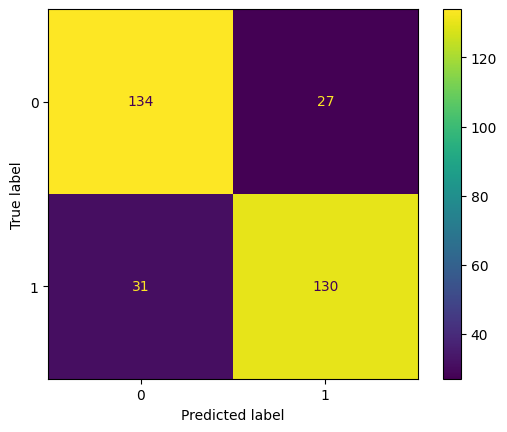

In [ ]:
# Evaluate the MLP
print('Multilayer perceptron')
y_pred = mlp.predict(X_test)
evaluate_model(y_test, y_pred, mlp)

Decision tree model
Accuracy = 0.8230
Precision = 0.8657
Recall = 0.8230
F1-score = 0.8177


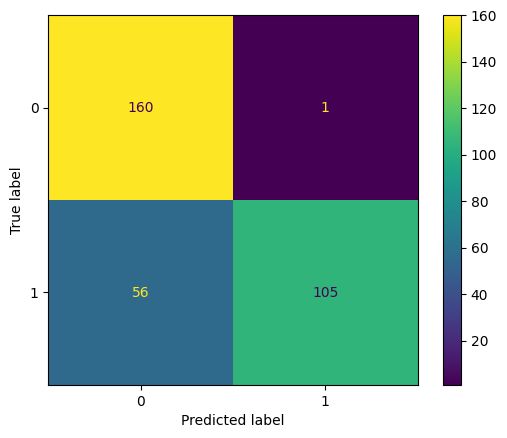

In [ ]:
# Evaluate the decision tree model
print('Decision tree model')
y_pred = dt.predict(X_test)
evaluate_model(y_test, y_pred, dt)

SVM model
Accuracy = 0.8975
Precision = 0.8988
Recall = 0.8975
F1-score = 0.8974


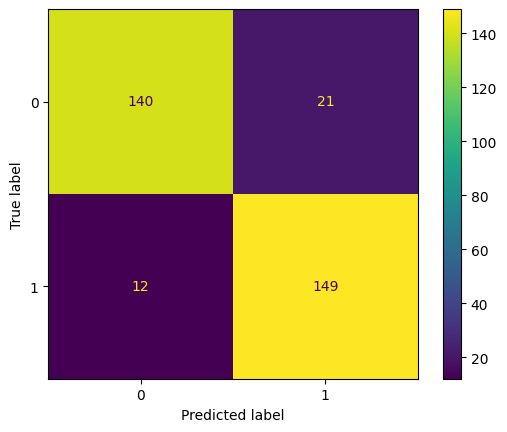

In [ ]:
# Evaluate the SVM model
print('SVM model')
y_pred = svm.predict(X_test)
evaluate_model(y_test, y_pred, svm)